In [1]:
# testing...
# https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

In [2]:
# if your kernel crashes after training
# use this setting
import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

<b>Load the data, let's examine the format</b>

In [4]:
# this is a highly unconventional way to load data
# we're gonna used pandas DataFrames in the next example
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [5]:
# x_train, amount of data in first level
len(x_train)

3601

In [6]:
# what is inside the first element of this large list?
print(len(x_train[5]))

# inspect this element
x_train[0]

500


array([-7.9717168e-01, -6.6439208e-01, -3.7301463e-01,  4.0815121e-02,
        5.2693599e-01,  9.8428794e-01,  1.3531202e+00,  1.5781078e+00,
        1.6592509e+00,  1.6408093e+00,  1.5522896e+00,  1.4379516e+00,
        1.2793537e+00,  1.0691193e+00,  7.4454700e-01,  2.7760541e-01,
       -3.0072351e-01, -9.3732792e-01, -1.5200828e+00, -1.9516165e+00,
       -2.1360326e+00, -2.0401363e+00, -1.7229406e+00, -1.2619003e+00,
       -8.0454833e-01, -4.6153436e-01, -2.7822475e-01, -2.5130000e-01,
       -3.0183001e-01, -3.1326381e-01, -2.0445830e-01,  6.7002208e-02,
        4.7161115e-01,  9.3265143e-01,  1.3531202e+00,  1.6444976e+00,
        1.7588356e+00,  1.6961341e+00,  1.4822114e+00,  1.1797690e+00,
        8.2569008e-01,  4.4948122e-01,  7.2534692e-02, -2.9703519e-01,
       -6.4595047e-01, -9.7421115e-01, -1.2508353e+00, -1.4094332e+00,
       -1.4278748e+00, -1.3024718e+00, -1.0627309e+00, -7.4922349e-01,
       -4.1727450e-01, -1.0745543e-01,  1.6879990e-01,  3.9784471e-01,
      

In [7]:
# x_train -> (the training variables)
# our data has 3601 elements of data
# each element has 500 points => 1 timesteps

In [8]:
# total number of signals in training data only
3601 * 500

1800500

In [9]:
# y_train only contains the target class, 
# it's either -1 or 1 at this point (2 classes)
# later we'll replace -1 with 0 (easier to handle with TensorFlow)
y_train[1]

1

In [10]:
# target values, what do we have?
y_train

array([-1,  1, -1, ..., -1,  1, -1])

In [11]:
# how much test data we have?
len(x_test)

1320

In [12]:
# for testing, approximately 27%
1320 / (3601 + 1320)

0.2682381629750051

<b>Try visualizing a bit.... (noise signals)</b>

<Figure size 640x480 with 0 Axes>

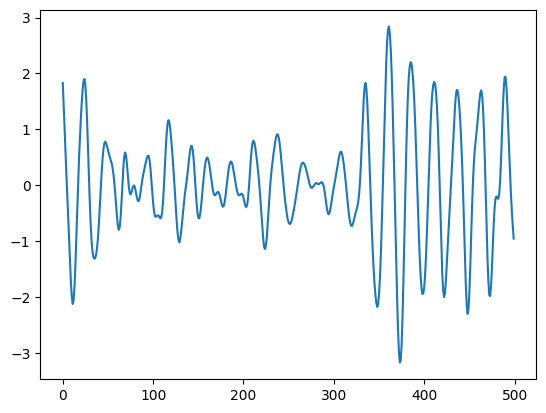

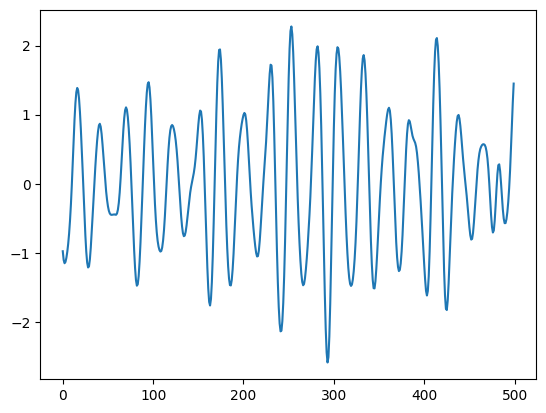

In [13]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

# change this to look at a different pair of signals
signal_index = 1500

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.figure()
    plt.plot(c_x_train[signal_index], label="class " + str(c))
    plt.show()


<b>Standardize the data</b>

In [14]:
# data format before standardization
x_train

array([[-0.79717168, -0.66439208, -0.37301463, ..., -0.66439208,
        -1.0737958 , -1.5643427 ],
       [ 0.80485472,  0.63462859,  0.37347448, ..., -0.71488505,
        -0.56044294, -0.31908642],
       [ 0.7279851 ,  0.11128392, -0.49912439, ...,  0.39446303,
         0.33940042,  0.25539062],
       ...,
       [-0.57005428, -0.33316523, -0.29351853, ..., -1.3937145 ,
        -0.94273327, -0.27072168],
       [ 2.0067321 ,  2.0791499 ,  2.0220362 , ..., -0.43214504,
        -0.44123126, -0.28070891],
       [-0.12524091, -0.32536268, -0.48823697, ...,  0.55576053,
         0.57445102,  0.57311598]])

In [15]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [16]:
# it seems to add another dimension to the NumPy array (three dimensions)
# and also wrap each individual point in each individual time step into its own list
# containing only one number value
x_train

array([[[-0.79717168],
        [-0.66439208],
        [-0.37301463],
        ...,
        [-0.66439208],
        [-1.0737958 ],
        [-1.5643427 ]],

       [[ 0.80485472],
        [ 0.63462859],
        [ 0.37347448],
        ...,
        [-0.71488505],
        [-0.56044294],
        [-0.31908642]],

       [[ 0.7279851 ],
        [ 0.11128392],
        [-0.49912439],
        ...,
        [ 0.39446303],
        [ 0.33940042],
        [ 0.25539062]],

       ...,

       [[-0.57005428],
        [-0.33316523],
        [-0.29351853],
        ...,
        [-1.3937145 ],
        [-0.94273327],
        [-0.27072168]],

       [[ 2.0067321 ],
        [ 2.0791499 ],
        [ 2.0220362 ],
        ...,
        [-0.43214504],
        [-0.44123126],
        [-0.28070891]],

       [[-0.12524091],
        [-0.32536268],
        [-0.48823697],
        ...,
        [ 0.55576053],
        [ 0.57445102],
        [ 0.57311598]]])

In [17]:
# this usually works in binary classification
# but it has a possibility of mixing up the class values
# in the next example, we are going to define this mapping manually
num_classes = len(np.unique(y_train))

In [18]:
# 2 classes is correct
num_classes

2

In [19]:
# shuffle the train(for a better learning result)
# and fix the -1 => 0 (for both train and test)

# NOTE! Only shuffle training data, NEVER SHUFFLE TESTING DATA
# (otherwise the error metrics will be completely wrong, because
# the data and the targets are now mismatched)
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# replace -1 => 0
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

<b>Build the model for the time series classification (CNN)</b>

In [20]:
# model with 3 convolutional layers + the rest of the neural network
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])

In [21]:
epochs = 500
batch_size = 32

# useful callbacks typically for time series
# or CNN in general
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

# usual combination
# this example uses sparse categorical crossentropy
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

# in a nutshell, normal vs sparse
# normal is = [0, 1]
# sparse is = 0      (or 1)

In [22]:
# load up the best version of the model
model = keras.models.load_model("best_model.keras")

# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)



42/42 [==============================] - 1s 9ms/step - loss: 0.0876 - sparse_categorical_accuracy: 0.9727
Test accuracy 0.9727272987365723
Test loss 0.08762075752019882


In [23]:
# plot the training accuracies
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [24]:
# plot the training loss results
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [25]:
# make predictions and use argmax
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

42/42 [==============================] - 0s 8ms/step


<Axes: >

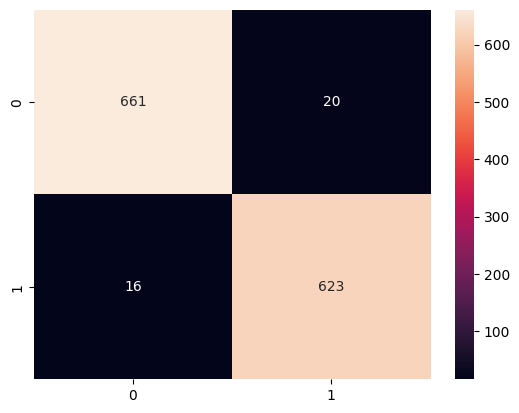

In [27]:
# confusion matrix, seems quite good
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [28]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       681
           1       0.97      0.97      0.97       639

    accuracy                           0.97      1320
   macro avg       0.97      0.97      0.97      1320
weighted avg       0.97      0.97      0.97      1320


Model overall accuracy: 97.27%


In [29]:
# roc auc score also very good
roc_auc_score(y_test, model.predict(x_test)[:, 1])

42/42 [==============================] - 0s 8ms/step


0.9944824765200766

In [35]:
# index 25 should identify as class 0
y_test[25]

0

In [36]:
# seems to match
model.predict([x_test[25]])[0]

16/16 [==============================] - 0s 973us/step


array([9.999990e-01, 9.948841e-07], dtype=float32)

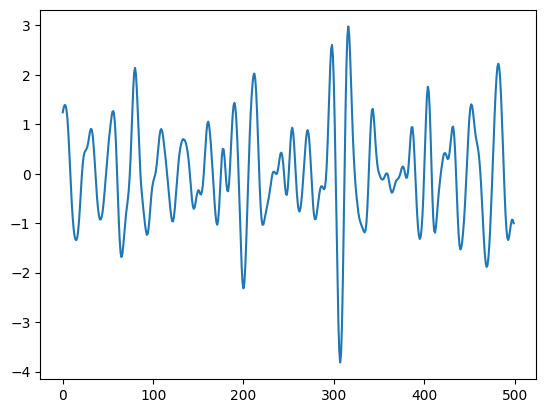

In [ ]:
# plot the figure for this signal
plt.figure()
plt.plot(x_test[25])
plt.show()